In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [2]:
# Leemos la imagen e imprimimos sus caracteristicas

img = cv.imread('Estrellas.png',cv.IMREAD_GRAYSCALE)

print('Estructura de la imagen: {}'.format(img.shape))
print('Cantidad total de pixeles: {}'.format(img.size))
print('Tipo de dato de cada pixel: {}'.format(img.dtype))

if len(img.shape)==3:
    print('Imagen COLOR')
else:
    print('Imagen BW')

Estructura de la imagen: (512, 512)
Cantidad total de pixeles: 262144
Tipo de dato de cada pixel: uint8
Imagen BW


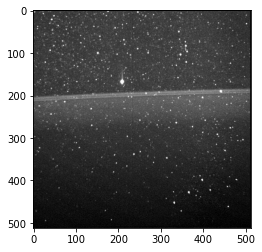

In [3]:
# Muestamos la imagen original

plt.imshow(img, cmap='gray');

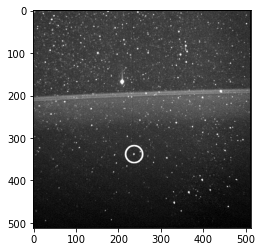

In [4]:
# Para encontrar la estrella mas brillante, primero intentamos buscando el pixel con mayor valor

(minVal, maxVal, minLoc, maxLoc) = cv.minMaxLoc(img) # Obtenemos valore y posicion de los pixeles máximos y mínimos
  
anotaciones = np.zeros(img.shape, dtype='uint8') # Creamos una máscara donde hacer las anotaciones
cv.circle(anotaciones, maxLoc,20,255,2,cv.LINE_AA) # Dibujamos un circulo en la posición encontrada

img_suma = cv.add(img,anotaciones)
plt.imshow(img_suma, cmap='gray');

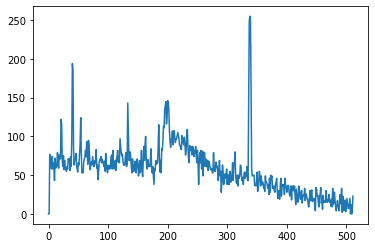

In [5]:
'''
Vemos que el pixel con un mayor valor no se corresponde con la estrella más brillante.
Esto se puede pasar porque la imagen original tiene bastente ruido, para ver que está pasando podemos hacer un perfil
de las intensidades en la columna que aparece este punto brillante.

'''

perfil = img[:,maxLoc[0]]
plt.plot(perfil)
plt.show()

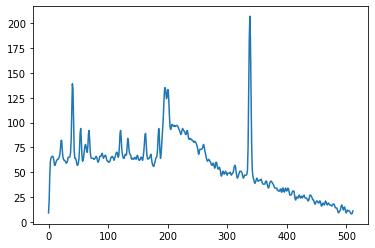

In [6]:
'''
Vemos en el perfil que es un solo un par de pixeles son los que tienen un valor de intensidad muy alto,
que no significa que sea un punto de mucho brillo sino que puede ser producto del ruido de la imagen.

Para poder solucionar esto, intentamos haciendo un blur gausiano de la imagen para mezclar los colores de cada pixel
con los de los pixeles vecinos, asi reduciendo el rudio.

Comparamos el mismo perfil, ahora con la imagen blureada.
'''

img_blur = cv.GaussianBlur(img,(5,5),0)
perfil = img_blur[:,maxLoc[0]]
plt.plot(perfil)
plt.show()

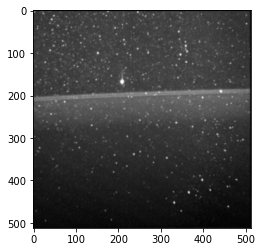

In [7]:
# Mostramos la imagen con el blur

plt.imshow(img_blur, cmap='gray');

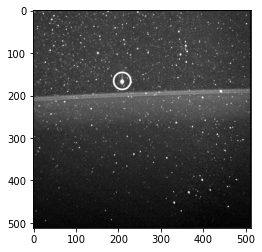

In [8]:
# Volvemos a buscar el punto mas brillante, ahora con la imagen procesada

(minVal, maxVal, minLoc, maxLoc) = cv.minMaxLoc(img_blur)
anotaciones = np.zeros(img.shape, dtype='uint8') 
cv.circle(anotaciones, maxLoc,20,255,2,cv.LINE_AA)
img_suma = cv.add(img,anotaciones)
plt.imshow(img_suma, cmap='gray');

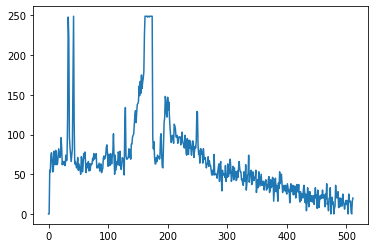

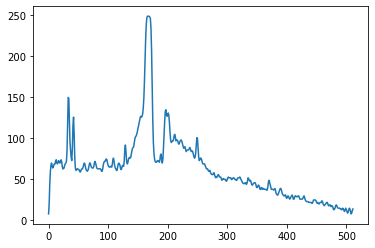

In [9]:
# Podemos ver el perfil de esta columna ahora.

perfil = img[:,maxLoc[0]]
plt.plot(perfil)
plt.show()

perfil = img_blur[:,maxLoc[0]]
plt.plot(perfil)
plt.show()

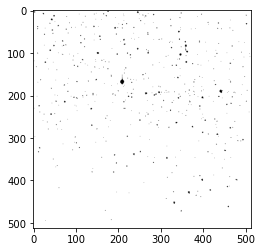

In [10]:
ret, mask = cv.threshold(img,160,255, cv.THRESH_BINARY_INV)

plt.imshow(mask, cmap='gray');

In [44]:
contornos, jerarquia = cv.findContours(mask,1,2)

estrellas = []

for i in contornos:
    area = cv.contourArea(i)
    if area > 3: # Pongo un radio minimo para evitar el ruido
        pos, radio = cv.minEnclosingCircle(i)
        pos_int = list(pos)  # Los elementos de la tupla tienen que ser int, pero tengo float
        pos_int[0] = int(pos_int[0])
        pos_int[1] = int(pos_int[1])
        pos = tuple(pos_int)
        cv.circle(anotaciones, pos,int(radio),255,2,cv.LINE_AA) 
    


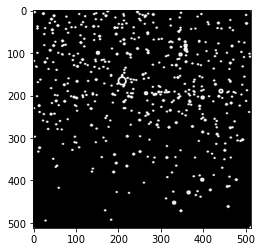

In [45]:
plt.imshow(anotaciones, cmap='gray');